In [1]:
from protein_sequence import ProteinSequence
from mutation_strategy import MutationStrategy, MinLogitPosSub, BlosumWeightedSub, MetropolisHastings
from evolution import Evolution
from evaluation_strategy import EvaluationStrategy
from model_singleton import ModelSingleton
import esm
from Bio.Align import substitution_matrices
import os

In [2]:
# Source: https://github.com/facebookresearch/esm/tree/main?tab=readme-ov-file#esmfold
model, alphabet = esm.pretrained.load_model_and_alphabet("esm2_t33_650M_UR50D") 
batch_converter = alphabet.get_batch_converter()

In [3]:
reference_seq = 'TTSAGESADPVTATVENYGGETQVQRRQHTDIAFILDRFVKVKPKEQVNVLDLMQIPAHTLVGALLRTATYYFSDLELAVKHEGDLTWVPNGAPETALDNTTNPTAYHKEPLTRLALPYTAPHRVLATVYNGSSKYGDTSTNNVRGDLQVLAQKAERTLPTSFNFGAIKATRVTELLYRMKRAETYCPRPLLAIQPSDARHKQRIVAPAKQ'

In [4]:
modelSingleton = ModelSingleton(model=model,alphabet=alphabet,batch_converter=batch_converter)

In [5]:
# mutation strategy parameters
mutations_per_seq = 4 # cap on size of potential mutation pool
min_pos = 1
max_pos = 212
constrained_start = 138 # start of high variability region
constrained_end = 143 # end of high variability region

blosum_matrix = substitution_matrices.load("BLOSUM80") 
multiplier=0.5 # for weighting blosum penalty 

mh_iterations = 10
mh_positions_per_seq = 3 # number of positions generated via mh
mh_mutations_per_seq = 3 # number of amino acids generated per pos

# evaluation strategy parameters
max_generations = 6

In [6]:
# constrained segment to mutate
segment = list(reference_seq)[constrained_start-1:constrained_end] # convert base-1 amino acid positions to base-0 for python indexing
for pos in range(constrained_start,constrained_end+1):
    print(f"Position {pos} : Amino Acid {segment[pos-constrained_start]}")

Position 138 : Amino Acid D
Position 139 : Amino Acid T
Position 140 : Amino Acid S
Position 141 : Amino Acid T
Position 142 : Amino Acid N
Position 143 : Amino Acid N


In [7]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence = fmd_sequence)
mutation_strat = MetropolisHastings(iterations=mh_iterations, positions_per_seq=mh_positions_per_seq, mutations_per_seq=mh_mutations_per_seq, start_pos=constrained_start,end_pos=constrained_end)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

In [8]:
evolution.evolve_sequence() # positions are 0-indexed, adjusted later for graph

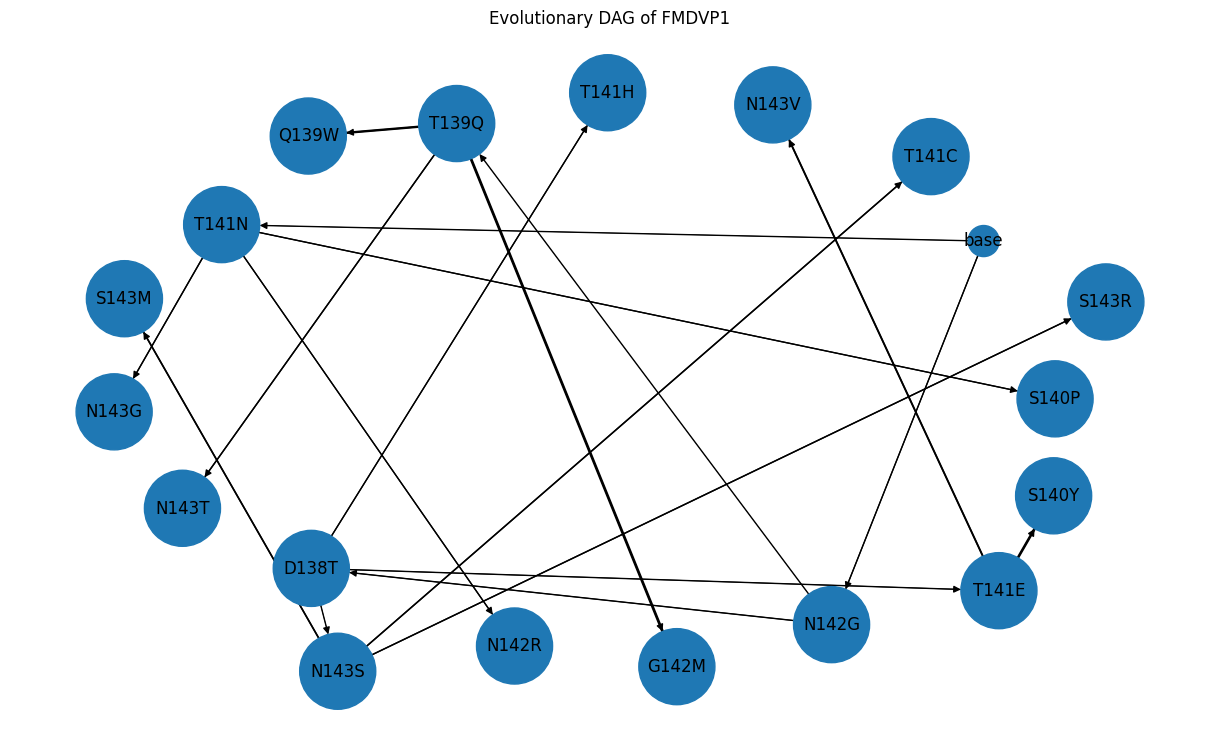

In [9]:
evolution.visualise_graph() 

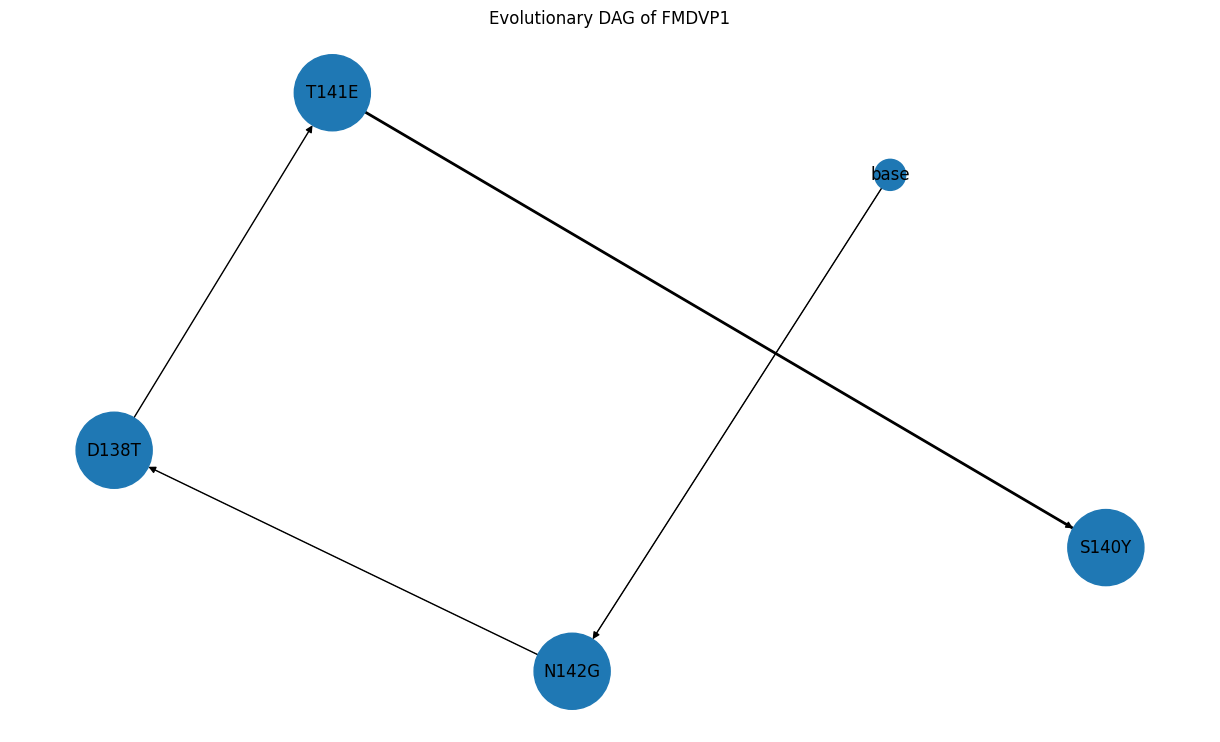

In [10]:
highest_score_path = evolution.get_path_with_highest_mutation_score()

In [11]:
alignments_file_path = os.path.join("evaluation", "FMDV_VP1_HVR_1571seq_aln.fas") # can I push this to my repo? or not supposed to be public?
evolution.evaluate_path_using_alignments(evolutionary_path=highest_score_path,file_path=alignments_file_path)

Percentage of mutation matches for base: n/a (root sequence)
Percentage of full segment matches for base: 0.6365372374283895
Percentage of mutation matches for N142G: 4.392106938255888
Percentage of full segment matches for N142G: 0.0
Percentage of mutation matches for D138T: 5.410566518141311
Percentage of full segment matches for D138T: 0.0
Percentage of mutation matches for T141E: 1.8459579885423298
Percentage of full segment matches for T141E: 0.0
Percentage of mutation matches for S140Y: 0.0
Percentage of full segment matches for S140Y: 0.0


In [ ]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence = fmd_sequence)
mutation_strat = MetropolisHastings(iterations=mh_iterations, positions_per_seq=mh_positions_per_seq, mutations_per_seq=mh_mutations_per_seq, start_pos=min_pos,end_pos=max_pos)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

In [11]:
evolution.evolve_sequence() 

[(86, 'P'), (155, 'F'), (86, 'F'), (155, 'A')]
[(185, 'N'), (185, 'A'), (148, 'I'), (148, 'L')]


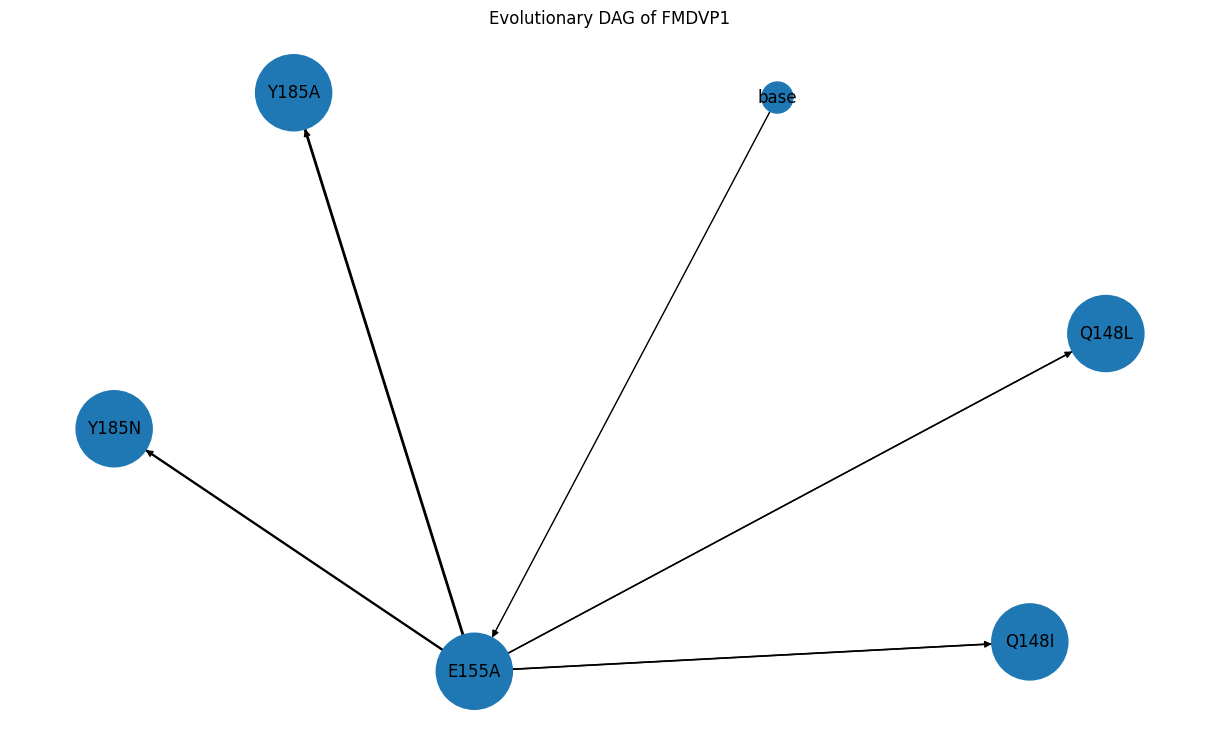

In [12]:
evolution.visualise_graph() 

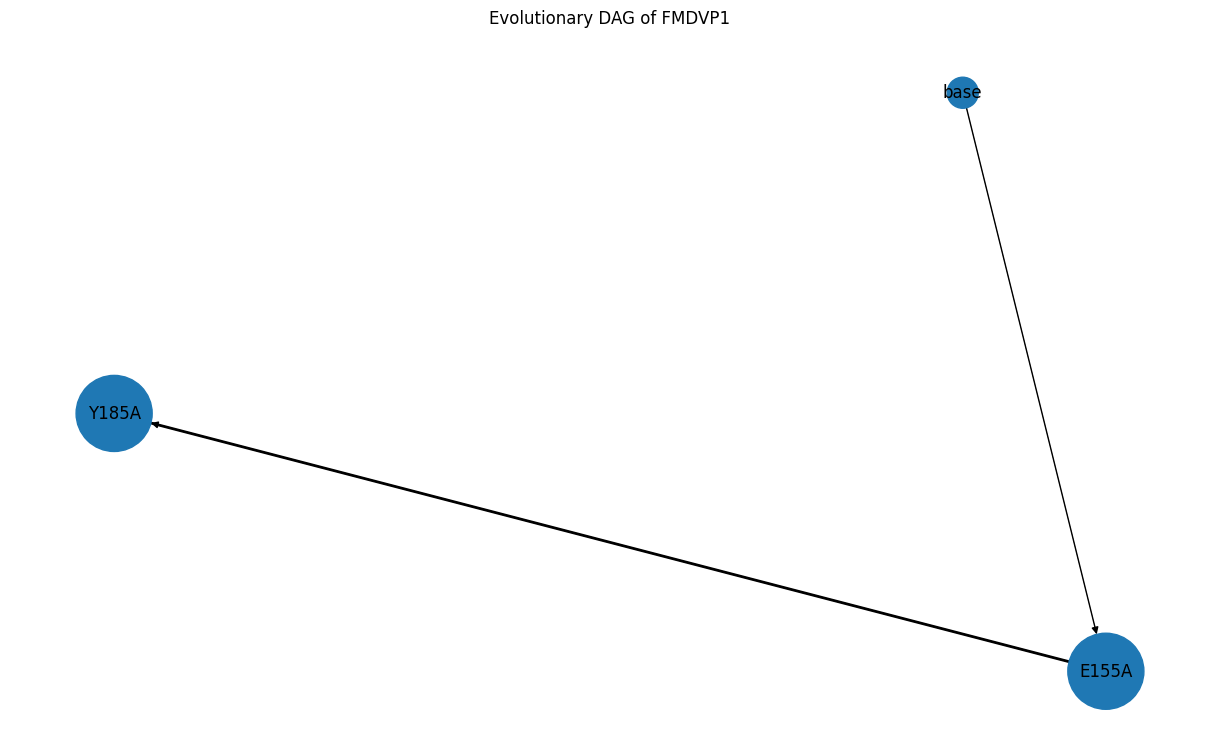

['base', 'E155A', 'Y185A']

In [13]:
evolution.get_path_with_highest_mutation_score()

In [ ]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence = fmd_sequence)
mutation_strat = MinLogitPosSub(mutations_per_seq=mutations_per_seq,start_pos=min_pos,end_pos=max_pos)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

In [ ]:
evolution.evolve_sequence()  # stops evolving when a mutation leads to a decreased mutation score - problem: next mutation is at the same position as it just happens to haev the lowest average logit scores again?

In [ ]:
evolution.visualise_graph() 

In [ ]:
evolution.get_path_with_highest_mutation_score()
# improve evaluation and leave it to filter out potential mutations rather than hardsetting, accept/reject policy, 
# what if i generate 100 different paths, what's the most likely paths that come up? rank these paths, want a population of possible paths  
# use alignments to assess closeness to actual path - ways to evaluate this and quantify the difference 

In [ ]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence=fmd_sequence)
mutation_strat = MinLogitPosSub(mutations_per_seq=mutations_per_seq,start_pos=constrained_start,end_pos=constrained_end)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

In [ ]:
evolution.evolve_sequence() 

In [ ]:
evolution.visualise_graph()

In [ ]:
evolution.get_path_with_highest_mutation_score()

In [ ]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence = fmd_sequence)
mutation_strat = BlosumWeightedSub(mutations_per_seq=mutations_per_seq,blosum_matrix=blosum_matrix,multiplier=multiplier,start_pos=min_pos,end_pos=max_pos)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

In [ ]:
evolution.evolve_sequence()   

In [ ]:
evolution.visualise_graph()

In [ ]:
evolution.get_path_with_highest_mutation_score()

In [ ]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence=fmd_sequence)
mutation_strat = BlosumWeightedSub(mutations_per_seq=mutations_per_seq,blosum_matrix=blosum_matrix,multiplier=multiplier,start_pos=constrained_start,end_pos=constrained_end)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

In [ ]:
evolution.evolve_sequence()   

In [ ]:
evolution.visualise_graph()

In [ ]:
evolution.get_path_with_highest_mutation_score()

In [ ]:
# prior to changing should_continue_mutating from checking if sequence probability is increasing to checking if overall mutatioon score is increasing and using the minimum average logit score per position rather than the minimum aa logit value
# experiment observation: constraining positions for mutation increases length of evolution path  
# this is not surprising as mutating the position least favoured by the PLM != mutating the position that will yield an increase in sequence probability 
# replacing the current amino acid at the lowest logit position does not automatically increase the sequence probability 
# this is because it may choose a position where mutations are unlikely to happen at to begin  with (ie highly conserved regions) 
# thus leading to an overall decrease on the sequence probability and structure similarity
# When mutations are contrained to positions we know are highly variable from observed data, this aligns with the PLM's knowledge of existing mutations
# such that mutating these highly variable position can lead to higher probability sequences as it expects mutations to occur in these positions